# Dog Breeds 
### Kaggle competition
![doggo](https://kaggle2.blob.core.windows.net/competitions/kaggle/7327/logos/header.png)

### Imports

NOTE: this notebook requires fastai lib to be in same dir
- can be done by symlinking fastai folder here
- same is done with the data folder\

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
ls fastai

fastai@


### CUDNN enabled

In [5]:
print(torch.cuda.is_available())
torch.backends.cudnn.enabled

True


True

#### set data and other config

In [6]:
PATH = "data/dog-breed-identification/"
arch=resnet34
sz=224
bs=64

### What do doggos look like

In [7]:
# create a validation set of id tags

label_csv = f'{PATH}labels.csv'
n = len (list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [8]:
label_df = pd.read_csv(label_csv)

In [59]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False).head()

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


# Steps
- Enable data augmentation, and `precompute=True`
- Use `lr_find()` to find the highest learning rate where loss is still clearly improving
- Train last layer from precomputerd activations for **1-2 epochs**
- Train last layer with data augmentation (precompute false ) for **2-3 epochs** with `cycle_len=1`
- Unfreeze all layers
- Set earlier layers to `3x -10x` lower learning rate than next higher layer
- Use `lr_find()` again
- Train full network with `cycle_mult=2` until over-fitting

### 1.

In [11]:
def get_data(sz, bs, aug=False):
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.jpg', bs=bs) if not aug else ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs) 
    return data if sz > 300 else data.resize(340, 'tmp')

In [12]:
# grab pretrained learner object with data etc
data = get_data(64, 40, aug=True)
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 39370922.59it/s]


In [13]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▊  | 161/205 [00:03<00:00, 46.80it/s, loss=23.7]


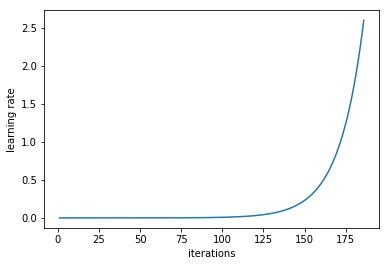

In [14]:
learn.sched.plot_lr()

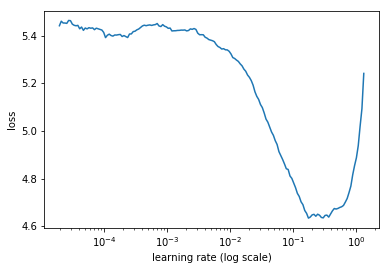

In [15]:
learn.sched.plot(n_skip_end=10)

In [16]:
1e-1

0.1

In [17]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.601511   3.084536   0.282692  
    1      3.070622   2.872234   0.296154                   



[2.872234, 0.2961538474147136]

In [97]:
learn.precompute=False

In [98]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 31%|███       | 63/205 [00:05<00:11, 12.39it/s, loss=2.96]

Exception in thread Thread-39:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      2.935738   2.76905    0.329808  
    1      2.942398   2.73655    0.325                      
    2      2.786907   2.699749   0.333173                   



[2.6997488, 0.33317307755351067]

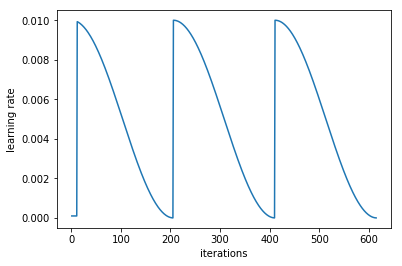

In [99]:
learn.sched.plot_lr()

In [105]:
64*2, 128*2, 299

(128, 256, 299)

In [92]:
learn.set_data(get_data(128, 40, aug=True))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [93]:
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.75219    2.767296   0.322596  
    1      2.643216   2.723546   0.332692                   
    2      2.519467   2.717662   0.334615                   



[2.7176623, 0.33461538329720497]

In [94]:
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.30167    2.692822   0.336058  
    1      2.296722   2.690681   0.344231                   



[2.6906805, 0.3442307707781975]

In [148]:
learn.unfreeze()

In [150]:
lrs = np.array([1e-4, 1e-3, 1e-2])

In [151]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.568698   1.226202   0.658173  
    1      1.445163   1.122253   0.679327                   
    2      1.28166    1.098117   0.690865                   
    3      1.306096   1.071885   0.6875                     
    4      1.198362   1.039706   0.697596                   
    5      1.121243   1.035021   0.698558                   
    6      1.074067   1.031775   0.699038                   



[1.0317745, 0.6990384574119861]

In [152]:
learn.save('128_full') 

In [171]:
1+2

3

In [153]:
learn.load('128_full')

In [154]:
learn.set_data(get_data(256, 40, aug=True))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [157]:
learn.freeze()

In [158]:
learn.precompute=True

In [163]:
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.263502   2.652755   0.362981  
    1      2.216267   2.667526   0.345673                   
    2      2.119786   2.668789   0.353365                   



[2.6687887, 0.35336538461538464]

In [164]:
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.981593   2.685206   0.35625   
    1      1.924767   2.709719   0.343269                   



[2.7097194, 0.343269231227728]

In [165]:
learn.precompute=False

In [166]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.9279     0.620975   0.809615  
    1      0.787605   0.563707   0.827885                    
 88%|████████▊ | 181/205 [03:41<00:29,  1.22s/it, loss=0.584]

In [169]:
learn.save('256_full')

In [ ]:
learn.load('256_full')

In [ ]:
learn.fit(np.array([1e-5, 1e-4, 1e-3 ]), 2 , cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.334708   0.49612    0.844231  
 50%|█████     | 103/205 [02:07<02:06,  1.24s/it, loss=0.334]

In [147]:
np.exp(log_preds[4])[:10]

array([[0.01924, 0.00041, 0.     , ..., 0.     , 0.00029, 0.00008],
       [0.00343, 0.00116, 0.00232, ..., 0.03779, 0.00422, 0.00364],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.00001],
       ...,
       [0.     , 0.00043, 0.00017, ..., 0.00002, 0.00001, 0.     ],
       [0.00012, 0.00057, 0.00036, ..., 0.01073, 0.01915, 0.00164],
       [0.00212, 0.00045, 0.0011 , ..., 0.00084, 0.0008 , 0.00696]], dtype=float32)

In [129]:
def create_submission_file(learn):
    log_preds, targs = learn.TTA(is_test=True)
    preds = np.exp(log_preds[0])
    
    breed_col = label_df.sort_values(by=['breed'])

    csv_headers = np.insert(np.unique(np.array(breed_col['breed'])), 0, 'id', axis=0); 
    fnames = list(map(lambda f: f.replace('test/', '').replace('.jpg', ''),data.test_dl.dataset.fnames))
    
    df = pd.DataFrame(data=preds, columns=uniq_breeds)
    df.insert(loc=0, column='id', value=fnames);
    
    df.to_csv(f'{PATH}submission.csv', index=False); 

In [170]:
create_submission_file(learn)